# Part I: Research Question

## A. Purpose of Data Mining Report
### A1. Research Question

Is it possible to forecast 90 days of future telecom revenue based on historical data with an ARIMA model?

### A2. Goals of the Data Analysis

The goal of this analysis is to determine if the revenue of the WGU Telecom Company can be predicted with an ARIMA model for use by stakeholders to develop strategies that will increase future revenue. This will be achieved by using the first 641 days of data as the training data set to forecast the latter 90 days of the data, and comparing the test data set with the forecast.
 
# Part II: Method Justification
## B. Assumptions of Time Series Models

- Stationarity: ARIMA models assume that the time series is (or can be made) stationary, meaning it lacks a trend or seasonality that changes over time. 
- Autocorrelation: ARIMA models assume that the time series is autocorrelated, meaning its current values are related to past values.

(Noble, 2024)

# Part III: Data Preparation
## C. Data Cleaning Process Summary

The cells below contain the code used to clean the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [3]:
# C. See code attached, in D213_PA_MendezD_T1.ipynb

# Load data into a data frame with Pandas' .read_csv() function
df = pd.read_csv('/Users/drewmendez/Documents/WGU/D213/data/teleco_time_series.csv')

print(df.shape)
print(df.head())
print(df.describe())

(731, 2)
   Day   Revenue
0    1  0.000000
1    2  0.000793
2    3  0.825542
3    4  0.320332
4    5  1.082554
              Day     Revenue
count  731.000000  731.000000
mean   366.000000    9.822901
std    211.165812    3.852645
min      1.000000    0.000000
25%    183.500000    6.872836
50%    366.000000   10.785571
75%    548.500000   12.566911
max    731.000000   18.154769


In [4]:
# C. Nulls

df.isnull().any()

Day        False
Revenue    False
dtype: bool

In [5]:
# C. Convert Day to Date

df['Day'] = (pd.date_range(start = datetime(2011, 1, 1),
                            periods = df.shape[0], freq = '24H'))

df.set_index('Day', inplace = True)
df = df.asfreq('D')

df.head()

,Revenue
Day,
2011-01-01,0.000000
2011-01-02,0.000793
2011-01-03,0.825542
2011-01-04,0.320332
2011-01-05,1.082554


### C1. Visualization of the Time Series

The graph below depicts Daily Revenue of the WGU Telecom Company as a function of Date, from January 1st, 2011 to January 1st, 2013. The trend of this line is shown by the line of best fit, graphed with a dashed green line.

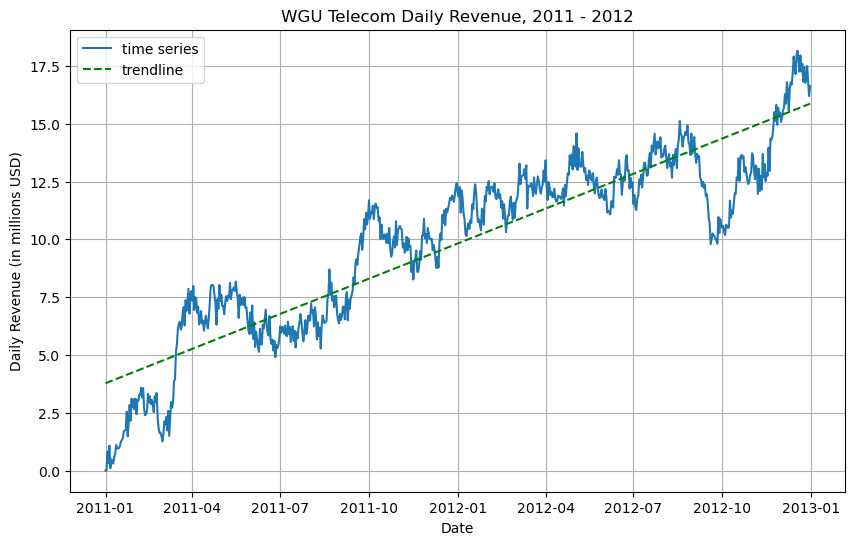

In [7]:
# C1. Visualizing Time Series Data

# Revenue vs Date
plt.figure(figsize = (10, 6))
plt.plot(df, label = "time series")
plt.title('WGU Telecom Daily Revenue, 2011 - 2012') 
plt.xlabel('Date')
plt.ylabel('Daily Revenue (in millions USD)')

# Trendline
x = mdates.date2num(df.index)
y = df.Revenue
z = np.polyfit(x, y, 1)
f = np.poly1d(z)
plt.plot(x, f(x), "g--", label = "trendline")

plt.legend()
plt.grid(True)
plt.show()


### C2. Time Step Formatting of the Realization

As shown above, this time series has no null or missing values, and therefore has no gaps in measurement. The time series describes daily revenue of the WGU Telecom Company, and contains a DateTime index corresponding to single day increments. The time series contains 731 observations, which reflects a full year plus a leap year with one extra day. Since the data dictionary does not allude to a year, the year data was re-formatted to reflect the years 2011 and 2012, the latter of which is the leap year.

### C3. Stationarity of the Time Series

For time series data to be stationary, the data must not exhibit any trend or seasonality (Santra, 2023). The above data appears to be non-stationary, as it is apparent that there is a positive trend, as evidenced by the positively-sloping line of best fit. This indicates that the data must be transformed into a stationary time series.

The Augmented Dicky-Fuller test can be used to confirm this observation. The null hypothesis when performing the Augmented Dicky-Fuller test is that the data is non-stationary, and requires a p-value less than 0.05 to reject the null hypothesis and conclude that the data is stationary. Upon performing the test below, the p-value is 0.32, so we fail to reject the null hypothesis and conclude that the data is non-stationary, and thus requires transformation. 

The `diff()` method will be used to transform the data into a stationary time series, which takes the difference of each successive datapoint. This will result in an empty observation on the first day, as there is no preceding day with which to take the difference. This empty value will be dropped from the transformed data.

In [9]:
# C3. Evaluating Stationarity

def check_stationarity(df):
    adf_result = adfuller(df)
    
    print(f"ADF Test Statistic: {round(adf_result[0], 4)}")
    print(f"p-value: {round(adf_result[1], 4)}")
    
    if adf_result[1] <= 0.05:
        print("Reject null hypothesis. The time series is stationary.")
    else:
        print("Fail to reject null hypothesis. The time series is non-stationary.")    

In [10]:
# C3. Evaluating Stationarity

check_stationarity(df)

ADF Test Statistic: -1.9246
p-value: 0.3206
Fail to reject null hypothesis. The time series is non-stationary.


Upon transforming the data and performing the Augmented Dickey-Fuller test on the newly transformed data, the p-value is 0.0, we can reject the null hypothesis at a confidence level of $\alpha = 0.05$ and conclude that the transformed data is stationary. This is evidenced visually in the graph of Differenced Daily Revenue vs Date shown below.

In [12]:
# C3. Transforming Data

df_stationary = df.diff().dropna().asfreq('D')

# ADF Test 
check_stationarity(df_stationary)

df_stationary.head()


ADF Test Statistic: -44.8745
p-value: 0.0
Reject null hypothesis. The time series is stationary.


,Revenue
Day,
2011-01-02,0.000793
2011-01-03,0.824749
2011-01-04,-0.505210
2011-01-05,0.762222
2011-01-06,-0.974900


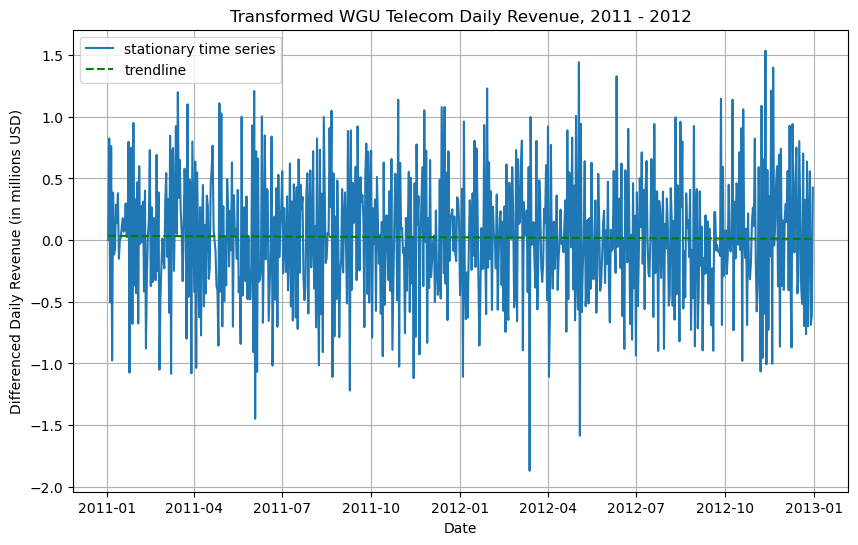

In [13]:
# C3. Visualizing Transformed Time Series Data

# Revenue vs Date
plt.figure(figsize = (10, 6))
plt.plot(df_stationary, label = "stationary time series")
plt.title('Transformed WGU Telecom Daily Revenue, 2011 - 2012') 
plt.xlabel('Date')
plt.ylabel('Differenced Daily Revenue (in millions USD)')

# Trendline
x = mdates.date2num(df_stationary.index)
y = df_stationary.Revenue
z = np.polyfit(x, y, 1)
f = np.poly1d(z)
plt.plot(x, f(x), "g--", label = "trendline")

plt.legend()
plt.grid(True)
plt.show()

### C4. Steps to Prepare Data for Analysis
Below are the steps used to prepare the data for analysis. Many of these steps were done above, so as to provide the visualizations above.

1. Import CSV to data frame
2. Check for null values using `.isnull().any()`
3. Change `Days` to YYYY/MM/DD format using `pd.date_range` and rename to `Date`
4. Make `Date` the index of the data frame using `.set_index()`
5. Check for stationarity of the data visually and with Augmented Dickey-Fuller Test
6. Transform data into a stationary time series using `diff()`
7. Split data into Train and Test data sets using `.iloc[]` with the last 90 days (12.3%) as the test data
8. Export Train and Test data sets to .csv

### C5. Copy of Cleaned Data Set
In order to provide .csv files for both the cleaned training and testing data, `.iloc[]` will be used below to split the data into the training and testing data sets. This is done for both the stationary and non-stationary data.

In [16]:
# Split data into Train and Test data sets

train = df.iloc[:-90]
test = df.iloc[-90:]

# Save Train dataframe to .csv
train.to_csv('D213_PA_MendezD_T1_train_nonstationary_clean.csv')

# # Save Test dataframe to .csv
test.to_csv('D213_PA_MendezD_T1_test_nonstationary_clean.csv')



# Split data into Train and Test data sets

train_stationary = df_stationary.iloc[:-90]
test_stationary = df_stationary.iloc[-90:]

# Save Train dataframe to .csv
train_stationary.to_csv('D213_PA_MendezD_T1_train_stationary_clean.csv')

# # Save Test dataframe to .csv
test_stationary.to_csv('D213_PA_MendezD_T1_test_stationary_clean.csv')

print(train.shape)
print(test.shape)

(641, 1)
(90, 1)


# Part IV: Model Identification and Analysis
## D. Analysis of the Time Series Data Set
### D1. Annotated Findings with Visualizations
The cells below include annotated visualizations of the following:

a) the decomposed time series \
b) the presence or lack of a seasonal component \
c) trends \
d) the autocorrelation function \
e) the spectral density \
f) confirmation of the lack of trends in the residuals of the decomposed series

### D1a. Time Series Decomposition
Below are the four graphs comprising the additive decomposition of the non-stationary time series. These graphs include the original observed time series, the trend or long-term direction of the time series, the seasonality component which can reveal repeating patterns, and the residuals which can reveal noise and irregularities. This decomposition is foundational for ARIMA modeling and forecasting.

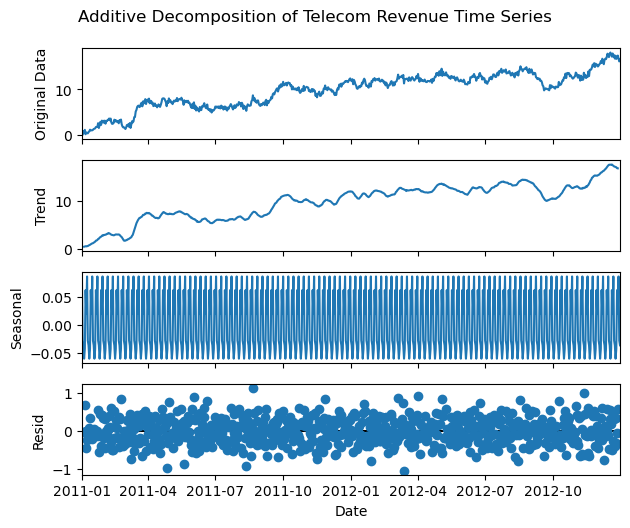

In [18]:
# D1a. Decomposed Time Series

decomposed_data = seasonal_decompose(df, model = 'Additive')

fig = decomposed_data.plot()
fig.axes[0].set_ylabel('Original Data', fontsize=10)
fig.suptitle('Additive Decomposition of Telecom Revenue Time Series', y=1.05, fontsize=12)
plt.xlabel('Date')
plt.show()

### D1b. Seasonal Component

The graph below shows the seasonal component of the decomposed non-stationary time series. There is evidence of a repetitive pattern which could indicate seasonality.

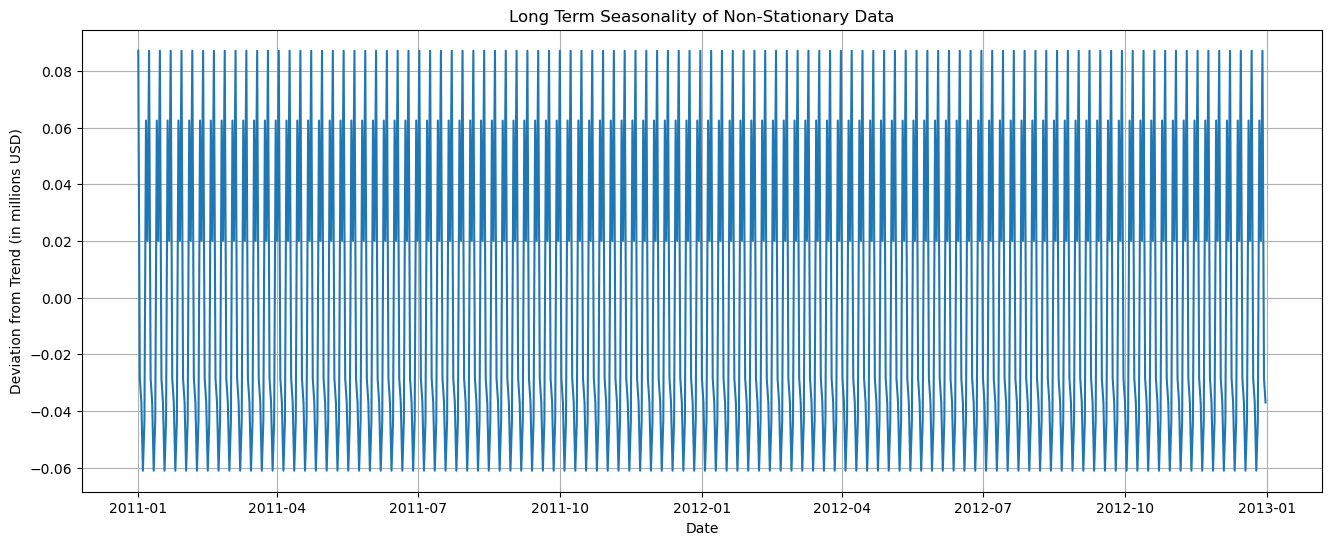

In [20]:
# D1b. Seasonal Component

plt.figure(figsize = [16, 6])
plt.plot(decomposed_data.seasonal)
plt.title('Long Term Seasonality of Non-Stationary Data')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend (in millions USD)')
plt.grid(True);

The graph below shows the seasonal component of the decomposed non-stationary time series, restricted to one month with red lines marking the seasonal cycle that repeats each week. This reveals a cyclical seasonal tendency that could be investigated further.

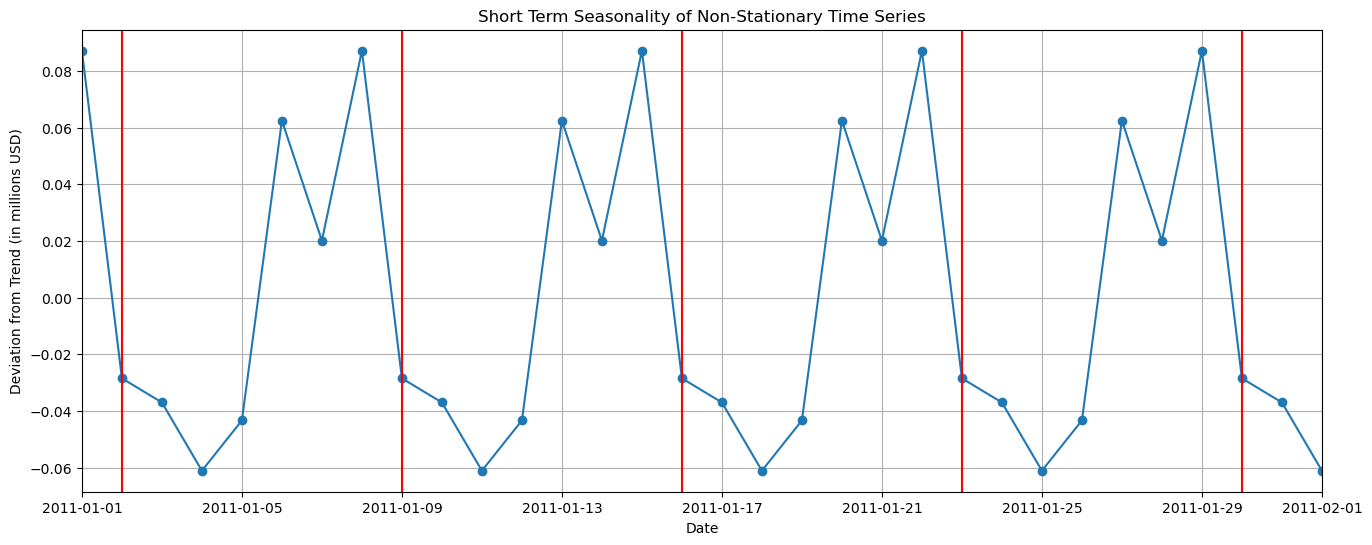

In [22]:
# D1b. Plot Seasonal Component

plt.figure(figsize = [16, 6])
plt.plot(decomposed_data.seasonal, marker = 'o')
plt.xlim(pd.to_datetime('2011-01-01'), pd.to_datetime('2011-02-01'))

# Plot red lines on Mondays
plt.axvline(x = pd.to_datetime('2011-01-02'), color = 'red')
plt.axvline(x = pd.to_datetime('2011-01-09'), color = 'red')
plt.axvline(x = pd.to_datetime('2011-01-16'), color = 'red')
plt.axvline(x = pd.to_datetime('2011-01-23'), color = 'red')
plt.axvline(x = pd.to_datetime('2011-01-30'), color = 'red')
plt.title('Short Term Seasonality of Non-Stationary Time Series')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend (in millions USD)')
plt.grid(True);

### D1c. Trend of Non-Stationary Data

The graph below shows the trend of the non-stationary data. The trend plot reveals a strong positive relationship between time and revenue, showing that growth is approximately linear, though minor deviations occur.

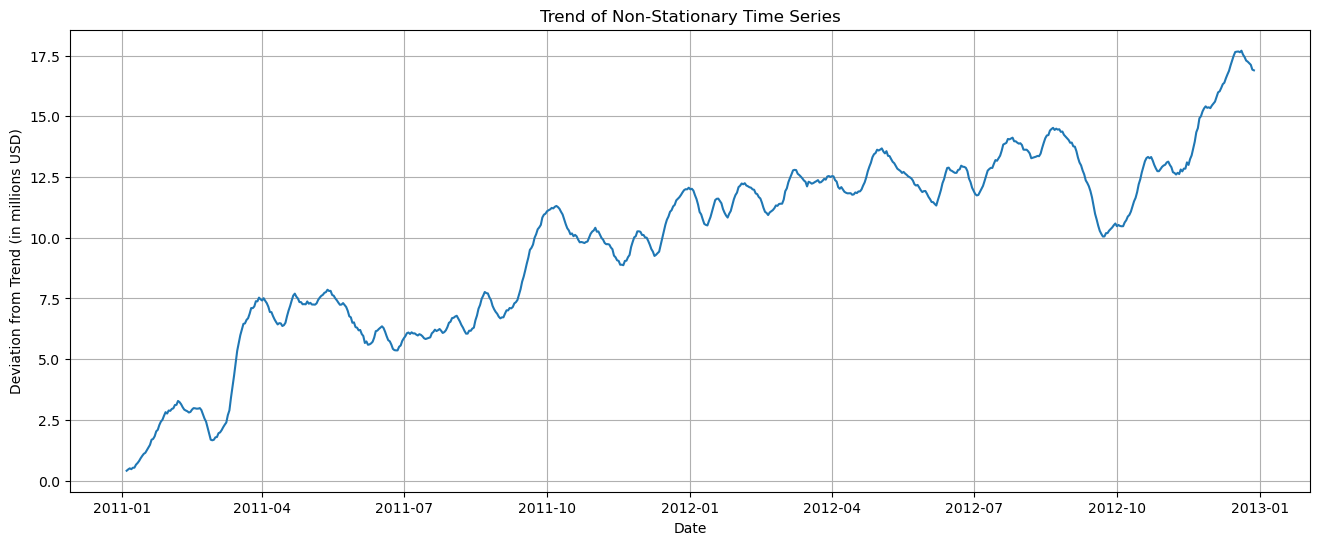

In [24]:
# D1c. Trend

plt.figure(figsize = [16, 6])
plt.plot(decomposed_data.trend)
plt.title('Trend of Non-Stationary Time Series')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend (in millions USD)')
plt.grid(True);

### D1d. Autocorrelation Function

The graphs below show the Autocorrelation Function and the Partial Autocorrelation Function. These can be used to determine the order of the autogression (AR) and moving average (MA) components of the model. The ACF tails off at 2 and the PACF cuts off at 1, which suggests that the model is best suited for AR(1) and MA(2), or rather ARMA(1, 2) (The Best of the Best Models, 2023). Since the time series is non-stationary and requires differencing with d = 1, a possible model would be ARIMA(1, 1, 2).

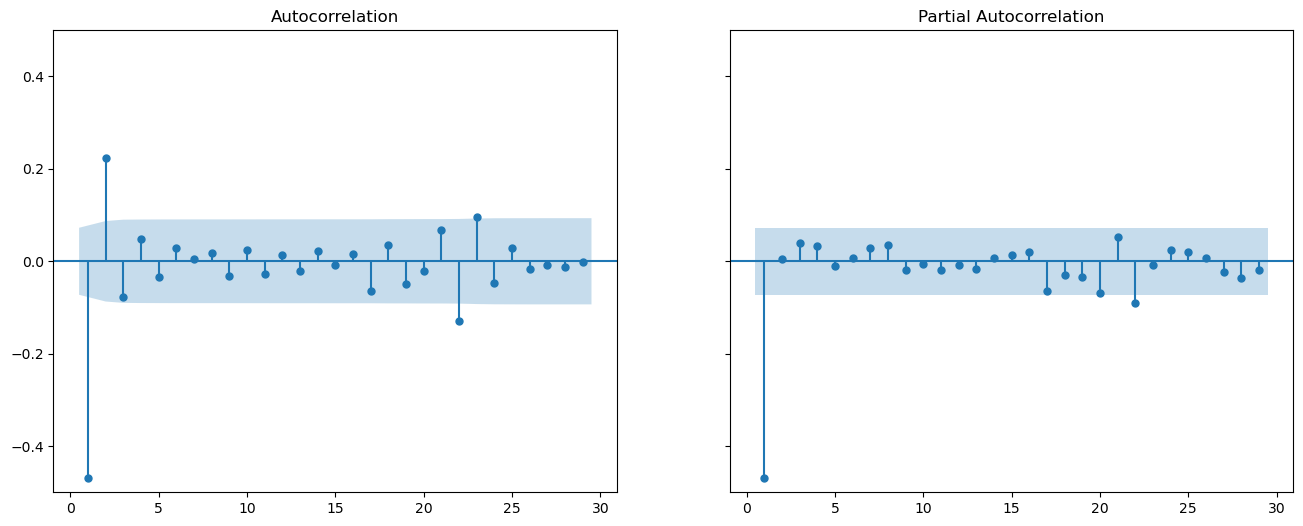

In [26]:
# D1d. Autocorrelation Functions 

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize = [16, 6], sharey = True)

# Plot ACF, ignore zero
plot_acf(df_stationary, zero = False, ax = axes[0])

# Plot PACF, ignore zero
plot_pacf(df_stationary, zero = False, ax = axes[1])

plt.ylim(-0.5, 0.5);

### D1e. Spectral Density

The graph below shows the graph of the power spectral density of the non-stationary time series. The power spectral density, or the power distribution across various frequencies, provides information regarding the signal's frequency components (Power Spectral Density, 2024).

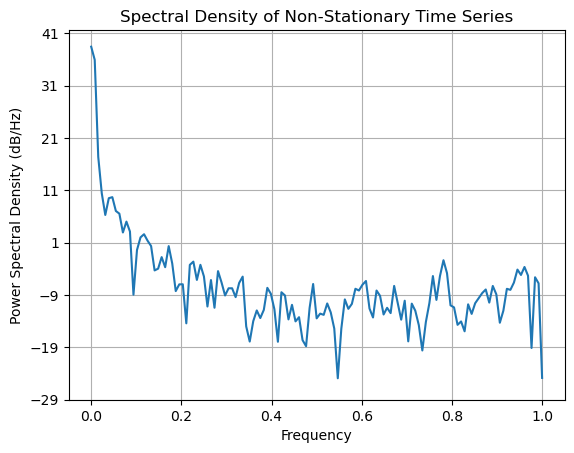

In [28]:
# D1e. Spectral Density

plt.psd(df['Revenue'])
plt.title('Spectral Density of Non-Stationary Time Series')
plt.show()

### D1f. Confirmation of Lack of Trends in Residuals

The graph of the residuals is shown below. Since there appears to be a random scatter of residuals with no apparent patterns or clusters, this confirms the lack of trend in the residuals of the non-stationary time series.

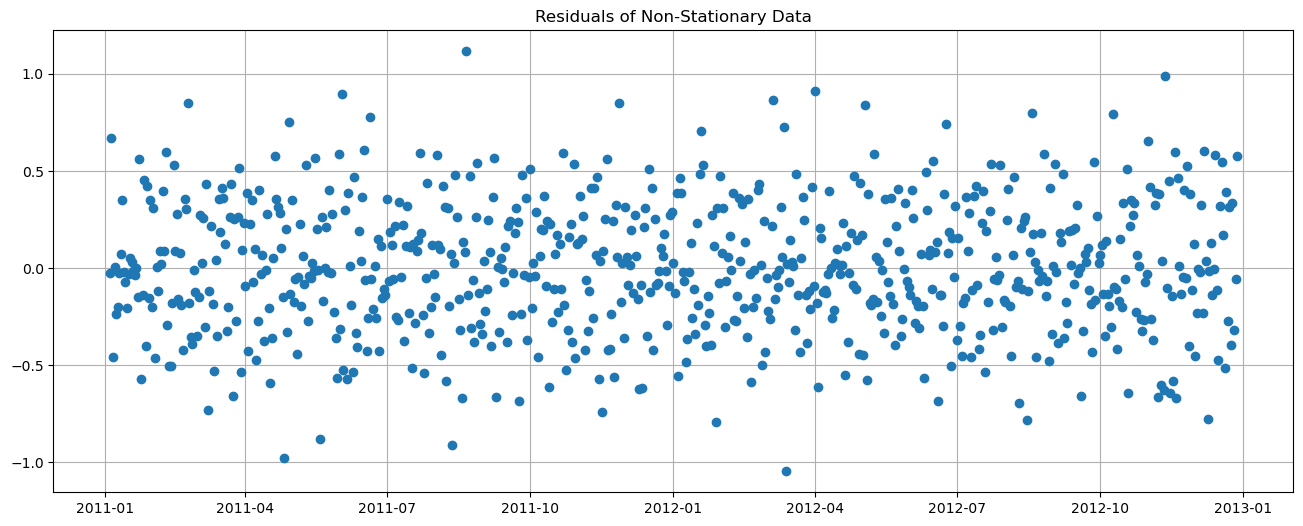

In [74]:
# D1f. Confirmation of Lack of Trends in Residuals

plt.figure(figsize = [16, 6])
plt.plot(decomposed_data.resid, marker='o', linestyle='none')
plt.title('Residuals of Non-Stationary Data')
plt.grid(True);


### D2. ARIMA Model
The code used to identify an ARIMA model that accounts for the observed trend and seasonality of the time series data is given below. A function was written that will loop through values of p and q, using d = 1 as the time series required differencing, in order to choose the best model using the AIC criteria. The model with the lowest AIC is ARIMA(1, 1, 0) as shown below.

To satisfy the requirements of the rubric, two models are created below, each with a different purpose for this analysis. The first model, `model_train`, was trained on the training data set in order to compare its forecast against the testing data. The second model, `model_full`, was trained on the full data set in order to provide the 90 day forecast past the testing data. The model summaries for both models are provided below.


In [32]:
# Pick best order by AIC based on smallest value
# d is the order of differencing
# Adapted from Dr Elleh's webinar

def best_arima_aic(df, d):
    best_aic = np.inf
    best_order = None

    best_mdl = None
    rng = range(4)
    for p in rng:
        for q in rng: 
            try:
                model = ARIMA(df, order=(p,d,q), enforce_stationarity=True)
                results = model.fit()
                tmp_aic = results.aic
                print(f"ARIMA({p},{d},{q}) - AIC: {tmp_aic:.2f}, BIC: {results.bic:.2f}")
                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, q)
                    best_mdl = model
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) - Failed: {str(e)}")
    if best_order is not None:
        print(f'\nBest Model: ARIMA{best_order} | AIC: {best_aic:.2f}')
        return best_mdl
    else:
        print("\nAll models failed to fit.")
        return None

In [33]:
# ARIMA on non-stationary time series

best_arima_aic(train, 1)

ARIMA(0,1,0) - AIC: 991.54, BIC: 996.00
ARIMA(0,1,1) - AIC: 875.58, BIC: 884.50
ARIMA(0,1,2) - AIC: 850.12, BIC: 863.51
ARIMA(0,1,3) - AIC: 848.77, BIC: 866.62
ARIMA(1,1,0) - AIC: 846.72, BIC: 855.64
ARIMA(1,1,1) - AIC: 848.65, BIC: 862.04
ARIMA(1,1,2) - AIC: 848.90, BIC: 866.74
ARIMA(1,1,3) - AIC: 850.70, BIC: 873.01
ARIMA(2,1,0) - AIC: 848.64, BIC: 862.02
ARIMA(2,1,1) - AIC: 849.70, BIC: 867.54


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,2) - AIC: 850.62, BIC: 872.93
ARIMA(2,1,3) - AIC: 852.61, BIC: 879.38
ARIMA(3,1,0) - AIC: 848.74, BIC: 866.59
ARIMA(3,1,1) - AIC: 850.68, BIC: 872.99
ARIMA(3,1,2) - AIC: 852.59, BIC: 879.36


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3,1,3) - AIC: 854.46, BIC: 885.69

Best Model: ARIMA(1, 0) | AIC: 846.72


In [34]:
# ARIMA on non-stationary time series

best_arima_aic(df, 1)

ARIMA(0,1,0) - AIC: 1162.14, BIC: 1166.73
ARIMA(0,1,1) - AIC: 1021.59, BIC: 1030.78
ARIMA(0,1,2) - AIC: 987.43, BIC: 1001.21
ARIMA(0,1,3) - AIC: 987.31, BIC: 1005.68
ARIMA(1,1,0) - AIC: 984.71, BIC: 993.90
ARIMA(1,1,1) - AIC: 986.65, BIC: 1000.43
ARIMA(1,1,2) - AIC: 986.82, BIC: 1005.19
ARIMA(1,1,3) - AIC: 988.30, BIC: 1011.26
ARIMA(2,1,0) - AIC: 986.64, BIC: 1000.42
ARIMA(2,1,1) - AIC: 986.86, BIC: 1005.23


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,2) - AIC: 988.09, BIC: 1011.06
ARIMA(2,1,3) - AIC: 990.11, BIC: 1017.67
ARIMA(3,1,0) - AIC: 987.18, BIC: 1005.55
ARIMA(3,1,1) - AIC: 988.07, BIC: 1011.04
ARIMA(3,1,2) - AIC: 990.07, BIC: 1017.63
ARIMA(3,1,3) - AIC: 991.89, BIC: 1024.05

Best Model: ARIMA(1, 0) | AIC: 984.71


In [35]:
# D2. ARIMA Model with Training Data Set

order = (1, 1, 0)

model_train = ARIMA(train, order = order)
results_train = model_train.fit()
results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  641
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -421.358
Date:                Sun, 06 Apr 2025   AIC                            846.716
Time:                        14:33:42   BIC                            855.639
Sample:                    01-01-2011   HQIC                           850.180
                         - 10-02-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4524      0.035    -12.962      0.000      -0.521      -0.384
sigma2         0.2184      0.013     16.662      0.000       0.193       0.244
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.97   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# D2. ARIMA Model with Full Data Set

model_full = ARIMA(df, order = order)
results_full = model_full.fit()
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Sun, 06 Apr 2025   AIC                            984.710
Time:                        14:33:42   BIC                            993.896
Sample:                    01-01-2011   HQIC                           988.254
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.98   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### D3. Forecast using ARIMA Model
The code to generate the 90-day forecast using the derived ARIMA model identified in part D2 is shown below. The model forecast is provided visually in the graph below, which shows the training data in blue, the 90 days of test data in green, and the 90-day forecast in dashed red with its 95% prediction interval in pink. Although the forecast does not follow the trend of the data, the prediction interval appears to capture the overall trend of the data.

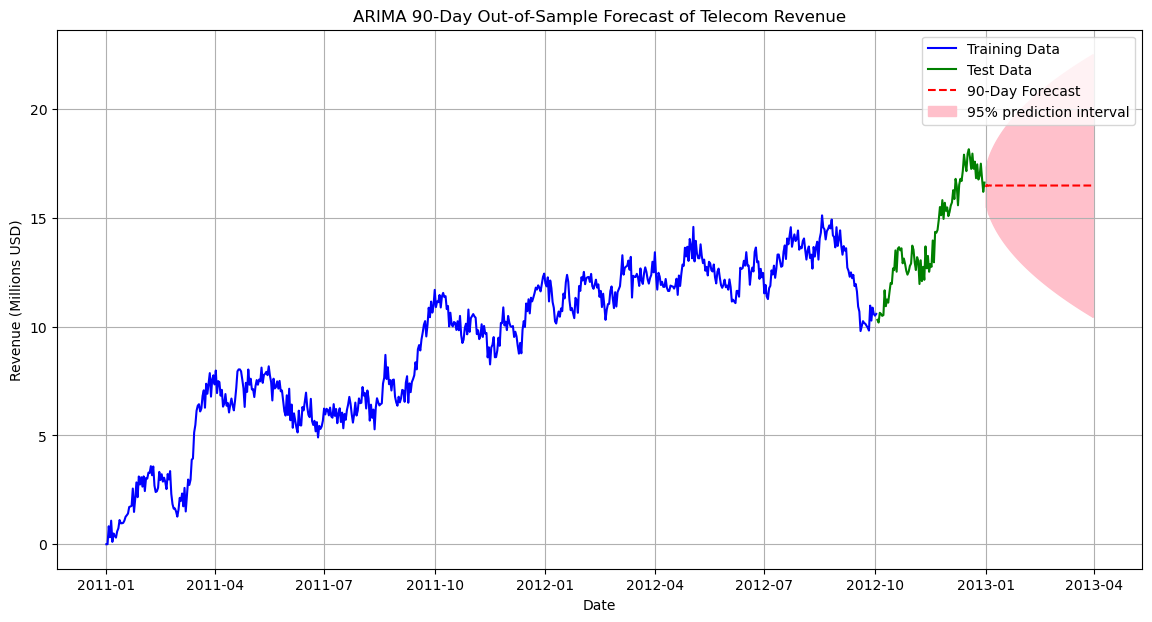

In [38]:
# D3 Generate 90-day forecast
forecast_full = results_full.get_forecast(steps=90)
forecast_mean_full = forecast_full.predicted_mean
conf_int_full = forecast_full.conf_int()

# Set future dates
future_dates = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=90)
forecast_mean_full.index = future_dates

# Confidence intervals
conf_int_full.index = future_dates
lower_limits_full = conf_int_full.loc[:, 'lower Revenue']
upper_limits_full = conf_int_full.loc[:, 'upper Revenue']

# Plot results
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['Revenue'], label='Training Data', color='blue')

# Plot test data
plt.plot(test.index, test['Revenue'], label='Test Data', color='green')

# Plot forecast
plt.plot(forecast_mean_full.index, forecast_mean_full, label='90-Day Forecast', linestyle='dashed', color='red')
plt.fill_between(conf_int_full.index, lower_limits_full, upper_limits_full, color = 'pink', label='95% prediction interval')

# Formatting
plt.title('ARIMA 90-Day Out-of-Sample Forecast of Telecom Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions USD)')
plt.legend()
plt.grid(True)
plt.show()

### D4. Analysis Output and Calculations
The output and calculations of the analysis performed here are provided in the preceding cells. The Root Mean Squared Error is calculated immediately below, and since the RMSE is low, the models generalizes well and the forecast with the full model is reliable.
The residual diagnostic plots are shown below as well. The standardized residual plots show that there are no visible patterns in the residuals as they have a random scattering around zero. The histogram plus density graphs show that the distribution of the residuals in approximately normal, which is emphasized by the normal Q-Q plots. Both correlograms indicate a good fit as there are no significant lags.



In [40]:
# D4. Output and Calculations

forecast_train = results_train.get_forecast(steps=90, dynamic=True)

# Values of the Test data set
actual_values = test['Revenue'].values 

# Forecasted values
forecasted_values = forecast_train.predicted_mean.values

# Calculate MSE
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 4.317669046992117


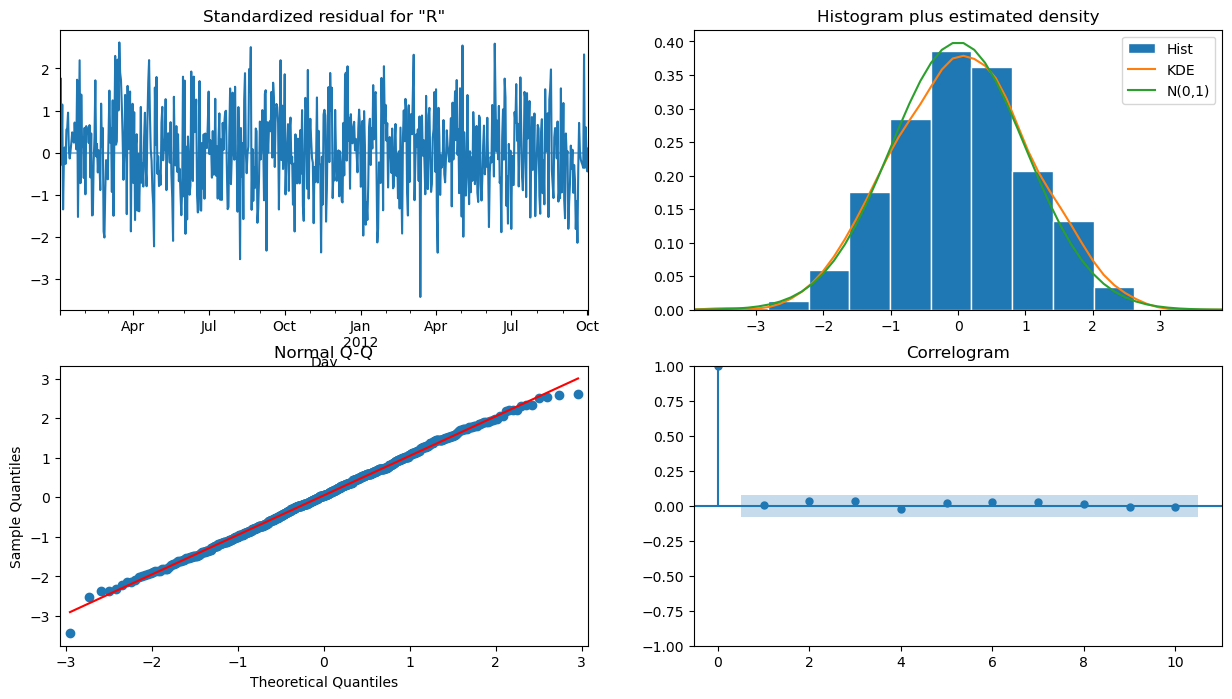

In [41]:
results_train.plot_diagnostics(figsize = (15, 8))
plt.show()

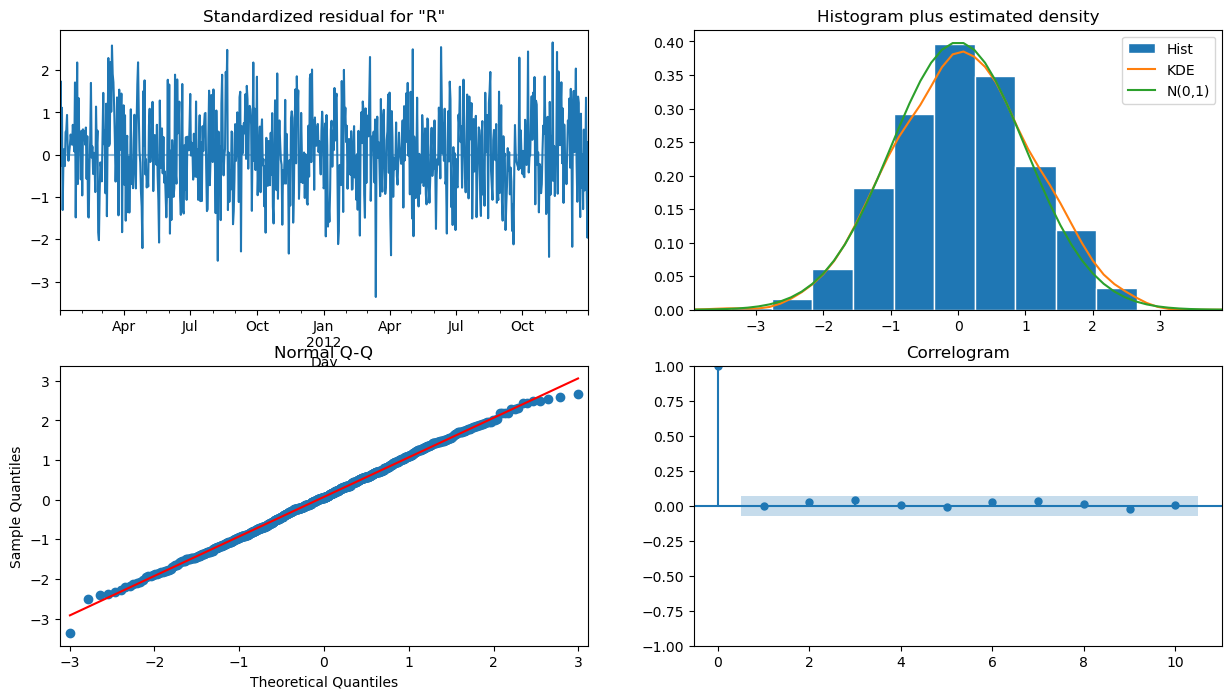

In [42]:
results_full.plot_diagnostics(figsize = (15, 8))
plt.show()

### D5. Code to Implement Time Series Model
The code used to support the implementation of the time series model is provided in the cells above.


# Part V: Data Summary and Implications
## E. Summary of Findings
### E1. Results of Analysis


- ARIMA Model Selection
    - The ARIMA model was selected by looping through values of p and q ranging from 0 to 2, comparing their AIC/BIC scores, and selecting the best model based on the lowest AIC score.
    - The model chosen is that of ARIMA(1, 1, 0), with d = 1 because the data required differencing.
- Forecast Prediction Interval
    - The default prediction interval of 95% was used, which means that we can expect 95% of future Revenue observations to lie within this range.
- Forecast Length Justification
    - The forecast length of 90 days is justified as the model is predicting less than one third of 24 months, or about 12% of the original data. 
- Model Evaluation and Error Metric
    - The Ljung-Box Test has a p-value > 0.05  which indicates that the residuals show no autocorrelation at lag 1.
    - The standardized residuals plot does not exhibit any patterns and the residuals are normally distributed.
    - The forecast of the model can be evaluated against the test data using the root mean squared error, which is shown above to be 4.7372. This means that, on average, the model's predictions are off by $\pm 4.7372$ million dollars.



### E2. Visualization of Forecast
Below is the annotated visualization of the forecast of the final model compared to the test set. The visualization provides the training data in blue, the testing data in green, the forecast in dashed red, and the 95% prediction interval in pink. The model does not appear to accurately model test data, although the test data does lie mostly within the prediction interval.

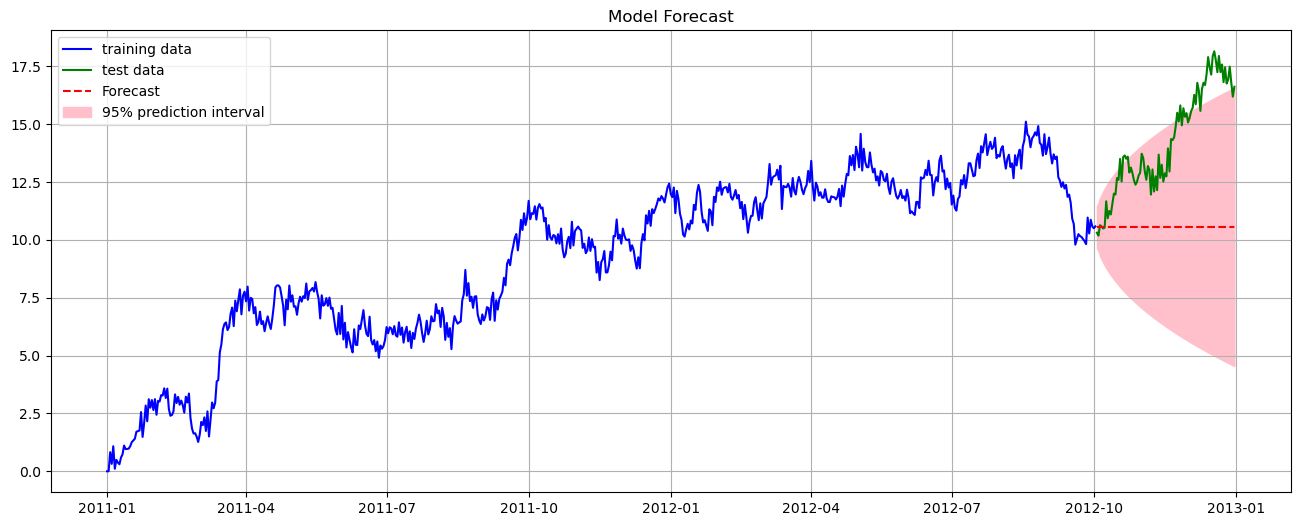

In [80]:
# E2. Visualization of Forecast

# Confidence Interval
conf_int_train = forecast_train.conf_int()
lower_limits_train = conf_int_train.loc[:, 'lower Revenue']
upper_limits_train = conf_int_train.loc[:, 'upper Revenue']

plt.figure(figsize = [16, 6])
plt.plot(train, color='blue', label='training data')
plt.plot(test, color='green', label='test data')
plt.plot(forecast_train.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(conf_int_train.index, lower_limits_train, upper_limits_train, color = 'pink', label='95% prediction interval')


plt.plot()
plt.legend()
plt.title('Model Forecast')
plt.grid(True)
plt.show()



### E3. Recommended Course of Action
While the model was able to make predictions 90 days into the future, the model could be improved upon. Based on this analysis, the recommended course of action would be to improve this model before using it to make additional predictions about future revenue. This could be done by exploring the seasonality observed here, as there appears to be a weekly cyclical pattern which could not be addressed due to using ARIMA in this analysis. The analysis could be improved upon by using SARIMAX to explore the seasonality component.


# Part VI: Reporting

## F. Report
All work completed in a Jupyter notebook and exported to PDF.

## G. Acknowledgement of Web Sources

Elleh, F. (n.d.). D213 Webinar Task 1 Data Preprocessing Python. Panopto; WGU. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8d32afc8-d66f-42d5-9117-b100016cf9ac

Elleh, F. (n.d.). D213 Task 1 Building Arima Model in Python. Panopto; WGU. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1aaf2389-6483-4000-b498-b14f00441d57



## H. Acknowledgement of Sources

Noble, J. (2024, May 24). ARIMA models. Ibm.com. https://www.ibm.com/think/topics/arima-model

Power Spectral Density - Derivation, Characteristics, Properties, Problems. (2024, February 27). GeeksforGeeks. https://www.geeksforgeeks.org/power-spectral-density/

Santra, R. (2023, May 12). Stationarity in Time Series. Medium. https://medium.com/@ritusantra/stationarity-in-time-series-887eb42f62a9

The Best of the Best Models - Intro to ACF and PACF. (2023). Datacamp.com; DataCamp. https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=1



